# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 3

# **Predição de séries temporais empregando vários tipos de modelos**
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo:  Série de temperatura mínima diária referente à cidade de Melbourne, Austrália, no período de 1981 a 1990.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Guilherme Rosa 

- A série de temperaturas mínimas diárias referente à cidade de Melbourne, Austrália, é composta por 3650 amostras.

- Pré-processamento - Normalização:

  - É feita uma normalização conhecida por *Standardization*, em que as amostras são subtraídas pela média da série temporal e em seguida são divididas pelo desvio padrão dela, resultando em uma série temporal com média nula e desvio padrão unitário. 

  - Essa etapa de normalização dos dados é feita com o objetivo de melhorar o processo de treinamento dos modelos, em particular do preditor não-linear.

- Pré-processamento - Construção dos pares entrada-saída e separação dos dados nos conjuntos de treinamento, validação e teste:

  - O problema de predição investigado é de um passo à frente.
  
  - O número de derivações de atraso utilizados para construção dos padrões de entrada dos preditores é igual a 20.

  - 210% das amostras são reservadas para validação e 10% para teste (essas amostras são extraídas sequencialmente no final).

  - Após a aplicação da função load_data, os conjuntos de treinamento, validação e teste são formados por, respectivamente, 2903, 393 e 393 amostras.

- Preditor linear:

  - O preditor linear é composto por 21 parâmetros, que combinam linearmente cada um dos atributos do padrão de entrada e o termo de polarização (bias).

- Preditor não-linear CNN-1D:

  - Estrutura:
      - 3 camadas convolucionais, cada uma com 10 kernels de dimensão 2, função de ativação ReLU e *stride* de 1.
      - Camada *fully-connected* com 64 neurônios com função de ativação ReLU.  
      - Camada de saída com apenas um neurônio com função de ativação linear.
  
  - Aspectos de treinamento:
      - Função custo: Erro Quadrático Médio
      - Algoritmo de otimização: Adam
      - Número de épocas: 50
      - Mini-batch com 32 amostras.
  
  - O melhor modelo, isto é, aquele que apresenta menor erro junto aos dados de validação, é obtido com auxílio do *callback* ModelCheckpoint. 



### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/'

# Specifi imports
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

df = pd.read_csv(path + 'daily-minimum-temperatures.csv', index_col=0)
series = np.array(df['Temp'])
print('Série original:')
print(f'Número de amostras: {series.shape[0]}.')
print(f'Valor máximo: {np.max(series)} -- Valor mínimo: {np.min(series)}.')
print('------------------------------------------------------------------------')

series_norm = (series - np.mean(series)) / (np.std(series))
print('Série com média zero e desvio padrão unitário:')
print(f'Valor máximo: {np.max(series_norm)} -- Valor mínimo: {np.min(series_norm)}.')
print(f'Média: {np.mean(series_norm)} -- Desvio padrão: {np.std(series_norm)}.')
print('------------------------------------------------------------------------')

print(series_norm[0:10])

Série original:
Número de amostras: 3650.
Valor máximo: 26.3 -- Valor mínimo: 0.0.
------------------------------------------------------------------------
Série com média zero e desvio padrão unitário:
Valor máximo: 3.7143723865669944 -- Valor mínimo: -2.7455139325727043.
Média: -1.6546885627290005e-16 -- Desvio padrão: 1.0.
------------------------------------------------------------------------
[2.33888328 1.65113873 1.87219948 0.84058266 1.13533032 1.13533032
 1.13533032 1.52832721 2.60906864 2.16694715]


### 6.3. Exibindo o comportamento temporal da série normalizada de temperaturas mínimas

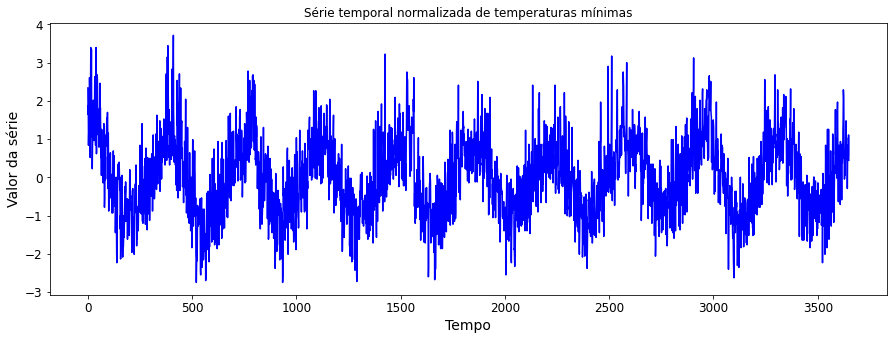

In [3]:
plt.figure(figsize=(15, 5));
plt.plot(series_norm, color='blue', label='open')
plt.title('Série temporal normalizada de temperaturas mínimas')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [4]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    # np.savetxt('Q6P3_x_train.txt', x_train)
    # np.savetxt('Q6P3_y_train.txt', y_train)
    # np.savetxt('Q6P3_x_valid.txt', x_valid)
    # np.savetxt('Q6P3_y_valid.txt', y_valid)
    # np.savetxt('Q6P3_x_test.txt', x_test)
    # np.savetxt('Q6P3_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 20 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2903, 20)
y_train.shape =  (2903, 1)
x_valid.shape =  (363, 20)
y_valid.shape =  (363, 1)
x_test.shape =  (363, 20)
y_test.shape =  (363, 1)


### 6.5. Visualização do comportamento da série temporal de teste

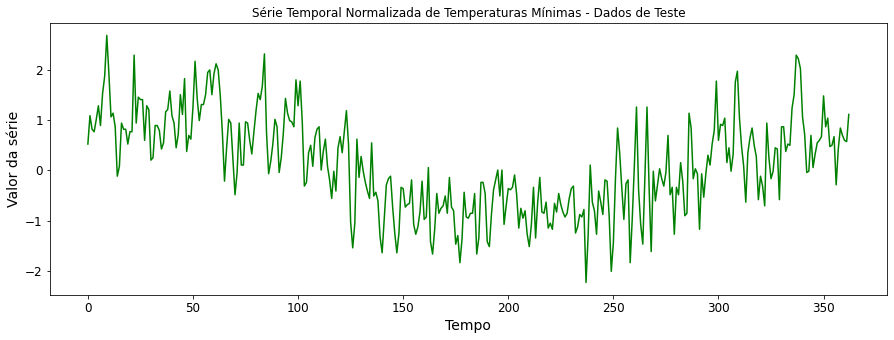

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Normalizada de Temperaturas Mínimas - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y_train)
w = lr.coef_
w = np.transpose(w)

print('Coeficientes do preditor linear:')
print(np.transpose(w))

Coeficientes do preditor linear:
[[ 0.03413023  0.00834662  0.04207909  0.00665281  0.01619461  0.01806026
   0.01297032  0.01752727  0.02020099  0.00371784  0.00830091  0.03409097
   0.02213558  0.04016316  0.02903353  0.04419521  0.03452072  0.05418052
  -0.08880222  0.58195938 -0.00304617]]


- Ao analisar os parâmetros do preditor linear, nota-se que a temperatura no instante atual tem a maior parcela de contribuição na predição do valor futuro, mostrando que o valor futuro e atual possuem forte correlação.

#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

y_pred_linear = X.dot(w)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.3604764105449172
EQM final de validação após o término do treinamento - Preditor Linear
0.27710884792488866
EQM final de teste após o término do treinamento - Preditor Linear
0.31070252522990105


### 6.7. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [8]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)

x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)

x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)


LATENT_DIM = 10
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 50

model_CNN = Sequential()
model_CNN.add(Conv1D(10, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(10, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(10, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dense(1, activation='linear'))
model_CNN.summary()

model_CNN.compile(optimizer='Adam', loss='mse')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 10)            30        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 10)            210       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 10)            210       
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,379
Trainable params: 13,379
Non-trainable params: 0
____________________________________________________

#### 6.10.1. Carregando o modelo com o menor MSE para o preditor CNN

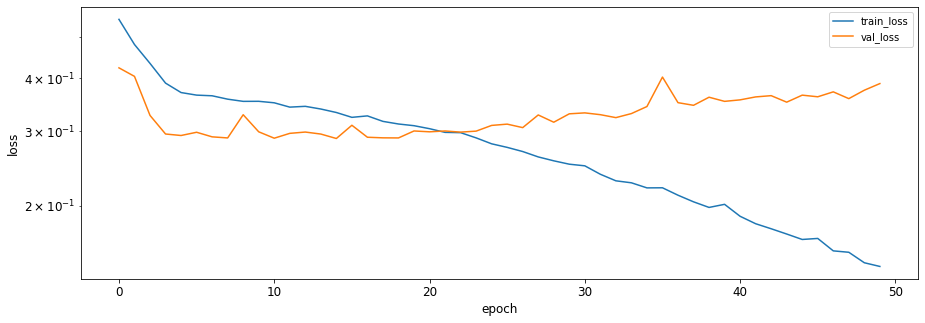

In [9]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [10]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)

print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)

print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

y_pred_CNN1D = model_CNN.predict(x_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.3147616160961393
EQM final de validação após o término do treinamento - Preditor CNN
0.28801121308889827
EQM final de teste após o término do treinamento - Preditor CNN
0.3233151760807035


### 6.8. Visualização das séries temporais de teste preditas sem a normalização

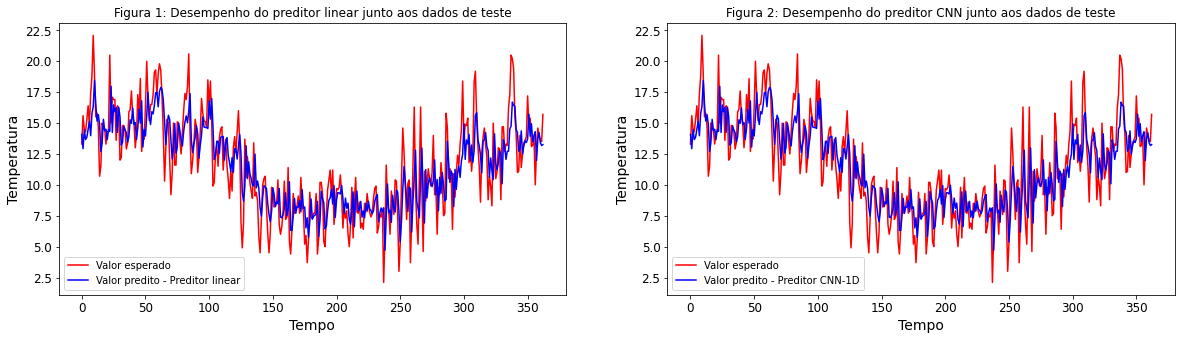

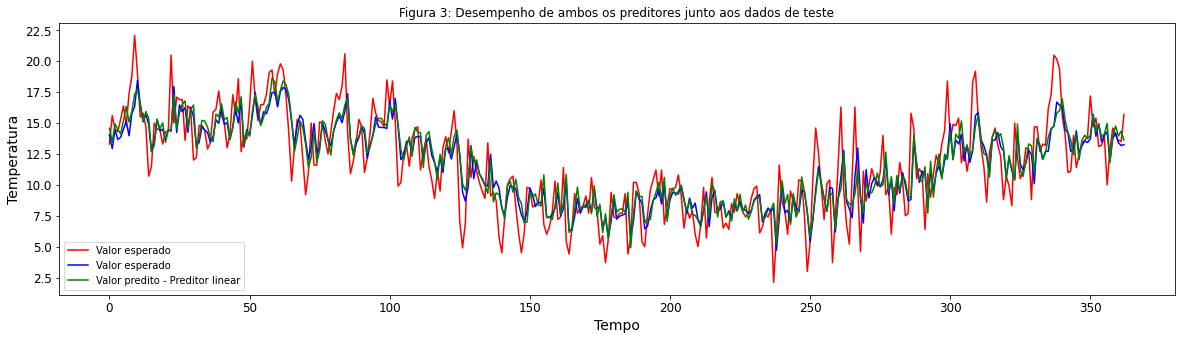

In [11]:
# Preditor Linear
y_pred_linear = X.dot(w)
temp_pred_linear = (y_pred_linear * np.std(series)) + np.mean(series)

# Preditor Não-linear CNN-1D
y_pred_CNN1D = model_CNN.predict(x_test)
temp_pred_CNN1D = (y_pred_CNN1D * np.std(series)) + np.mean(series)

# Série desejada:
temp_test = (y_test * np.std(series)) + np.mean(series)

fig = plt.figure(figsize=(20, 5))

fig.add_subplot(1, 2, 1)
plt.plot(temp_test, color='red', label='Valor esperado')
plt.plot(temp_pred_linear, color='blue', label='Valor predito - Preditor linear')
plt.title('Figura 1: Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend(loc='best')

fig.add_subplot(1, 2, 2)
plt.plot(temp_test, color='red', label='Valor esperado')
plt.plot(temp_pred_linear, color='blue', label='Valor predito - Preditor CNN-1D')
plt.title('Figura 2: Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.show()

fig = plt.figure(figsize=(20, 5))

plt.plot(temp_test, color='red', label='Valor esperado')
plt.plot(temp_pred_linear, color='blue', label='Valor esperado')
plt.plot(temp_pred_CNN1D, color='green', label='Valor predito - Preditor linear')
plt.title('Figura 3: Desempenho de ambos os preditores junto aos dados de teste')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend(loc='best')
plt.show()

- Como pode ser observado nas Figuras 1 e 2, ambos os preditores foram capazes de acompanhar o comportamento de variação da série original.
  
- Contudo, nota-se na Figura 3 que as séries preditas não atingem os valores exatos da série original quando ela apresenta variações muito abruptas de temperatura.

- Analisando o erro quadrático médio pode-se dizer que o preditor linear possui um desempenho levemente superior ao preditor não-linear CNN-1D.

- Por fim, podemos concluir que o uso desses preditores é adequado para ter uma estimativa sobre a direção (aumento ou redução) na temperatura num instante futuro.